What is the Pix2Pix GAN?

Pix2Pix is a Generative Adversarial Network, or GAN, model designed for general purpose image-to-image translation. The model is type of conditional GAN, or cGAN, where the generation of the output image is conditional on an input.

The GAN architecture is comprised of a generator model and a discriminator model. The generator model is responsible for outputting new plausible synthetic images. The discriminator is provided both with the generated image(produced by the generator model) and the target image and is responsible for classifying the generated image as real(from the dataset) or fake(generated). The discriminator model is updated directly, whereas the generator model is updated via the discriminator model. As such, the two models are trained simultaneously in an adversarial process where the generator seeks to better to fool the discriminator and the discriminator seeks to better identify the counterfeit images.

The generator is trained via adversarial loss, which encourages the generator to generate plausible images in the target domain. The generator is also updated via the L1 loss measured between the generated image and the expected target image. The additional loss encourages the generator model to create plausible translations of the source image.

In [1]:
from os import listdir
from numpy import asarray
from keras_preprocessing.image import img_to_array
from keras_preprocessing.image import load_img
from numpy import savez_compressed
from tqdm import tqdm
from numpy import load
from matplotlib import pyplot

Dataset

Link = https://www.kaggle.com/datasets/prasoonkottarathil/face-mask-lite-dataset.
The train folder(with_mask) contains 10,000 masked images of individuals. The validation folder(without_mask) contains 10,000 unmasked images of corresponding individuals. Images are in PNG format and each image is 1,024 pixels wide and 1,024 pixels tall.

We can prepare the dataset for training a Pix2Pix GAN model in Keras. Each image from the two folders(with_mask and without_mask) will be loaded and rescaled. The result will be two NumPy arrays containing the masked images and unmasked images with the width and height of 256x256 pixels.

The load_images() function below implements this. It enumerates the list of images in the two given directories, loads each with the target size of 256x256 pixels.

In [2]:
def load_images(mpath, nmpath, size = (256, 256)):
    mtemp, nmtemp = list(), list()
    mlist, nmlist = list(), list()

    for filename in tqdm(listdir(mpath)):
        mtemp.append(mpath + filename)
    
    for filename in tqdm(listdir(nmpath)):
        nmtemp.append(nmpath + filename)

    mtemp.sort()
    nmtemp.sort()

    for filename in tqdm(mtemp):
        img = img_to_array(load_img(filename, target_size=size))
        mlist.append(img)

    for filename in tqdm(nmtemp):
        img = img_to_array(load_img(filename, target_size=size))
        nmlist.append(img)

    return [asarray(mlist), asarray(nmlist)]

We call this function with the path to the training folder and the validation folder. Once loaded, we can save the prepared arrays to a new file in compressed format for later use.

In [9]:
mpath = '/Applications/ML projects/Unmask/archive/with_mask/'
nmpath = '/Applications/ML projects/Unmask/archive/without_mask/'

[mlist, nmlist] = load_images(mpath, nmpath)

filename = 'imgs_256.npz'
savez_compressed(filename, mlist, nmlist)
print('Saved dataset: ', filename)

100%|██████████| 10000/10000 [11:47<00:00, 14.14it/s]


Saved dataset:  imgs_256.npz


The file 'imgs_256.npz' can be loaded later via the load() NumPy function and retrieving each array in turn. We plot some images to confirm the data has been handled correctly

In [3]:
data = load('imgs_256.npz')
mlist, nmlist = data['arr_0'], data['arr_1']
print('Loaded: ', mlist.shape, nmlist.shape)

Loaded:  (10000, 256, 256, 3) (10000, 256, 256, 3)


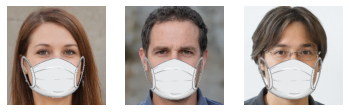

In [7]:
n_samples = 3
for i in range(n_samples):
    pyplot.subplot(2, n_samples, 1 + i)
    pyplot.axis('off')
    pyplot.imshow(mlist[i].astype('uint8'))

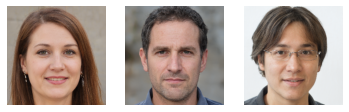

In [8]:
for i in range(n_samples):
    pyplot.subplot(2, n_samples, 1 + i)
    pyplot.axis('off')
    pyplot.imshow(nmlist[i].astype('uint8'))

How to Develop and Train a Pix2Pix Model?

The implementation in this section will use a Keras deep learning. The GAN model is designed to take and generate color images with the size of 256x256 pixels.

The architecture is comprised of two models: the generator and the discriminator model.

The discriminator model follow the PatchGAN architecture. The architecture is designed so that the each output prediction of the model maps to 70x70 patch of the input image. The advantage of this architecture is that the same model can be applied to input images of different sizes. Each value is a probability for the likelihood that a patch in the input image is real.

In [3]:
from numpy import zeros
from numpy import ones
from numpy.random import randint
from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras.layers import Dropout
from keras.layers import BatchNormalization

Discriminator

The define_discriminator() function below implements a discrminator model. The model takes two input images i.e. the output image and the target image. The two images are concatenated together. The model is optimized using binary cross entropy, and a weighting is used so that updates to the model have half (0.5) the usual effect.

In [4]:
def define_discriminator(image_shape):
    init = RandomNormal(stddev=0.02)

    mimg = Input(shape=image_shape)
    nmimg = Input(shape=image_shape)

    merged = Concatenate()([mimg, nmimg])

    d = Conv2D(64, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(merged)
    d = LeakyReLU(alpha=0.2)(d)

    d = Conv2D(128, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)

    d = Conv2D(256, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)

    d = Conv2D(512, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)

    d = Conv2D(512, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)

    d = Conv2D(1, (4, 4), padding='same', kernel_initializer=init)(d)
    patch_out = Activation('sigmoid')(d)

    model = Model([mimg, nmimg], patch_out)

    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])
    return model

Generator

The generator model is more complex than the discriminator model.

The generator follows a U-Net architecture which possesses an encoder-decoder model. The model takes a source image and generates a target image. It does it by first downsampling or encoding the input image(mask image) to the bottleneck layer, then upsampling or decoding the bottleneck representation to the size of the output image. The U-Net architecture possesses skip connections between the encoding layers and the corresponding decoding layers, forming a U-shape.

The encoder and the decoder of the generator are comprised of blocks of convolution, batch normalization, dropout and activation layers. 
Separate helper functions are developed to create each block of layers and called repeatedly to build the encoder and the decoder parts of the model.

In [5]:
def define_encoder_block(layer_in, n_filters, batchnorm=True):
    init = RandomNormal(stddev=0.02)
    g = Conv2D(n_filters, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(layer_in)
    if batchnorm:
        g = BatchNormalization()(g, training=True)
    g = LeakyReLU(alpha=0.2)(g)
    return g

In [6]:
def define_decoder_block(layer_in, skip_in, n_filters, dropout=True):
    init = RandomNormal(stddev=0.02)
    g = Conv2DTranspose(n_filters, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(layer_in)
    g = BatchNormalization()(g, training=True)
    if dropout:
        g = Dropout(0.5)(g, training=True)
    g = Concatenate()([g, skip_in])
    g = Activation('relu')(g)
    return g

The define_generator() function below implements the U-Net architecture. It uses the define_encoder_block() and the define_decoder_block() function to create blocks of encoder layers and decoder layers respectively. The tanh activation function is used in the output layer, meaning that pixel values in the output layers, meaning that pixel values in the generated image will be in the range [-1, 1].

In [7]:
def define_generator(image_shape=(256, 256, 3)):
    init = RandomNormal(stddev=0.02)
    in_image = Input(shape=image_shape)

    e1 = define_encoder_block(in_image, 64, batchnorm=False)
    e2 = define_encoder_block(e1, 128)
    e3 = define_encoder_block(e2, 256)
    e4 = define_encoder_block(e3, 512)
    e5 = define_encoder_block(e4, 512)
    e6 = define_encoder_block(e5, 512)
    e7 = define_encoder_block(e6, 512)

    b = Conv2D(512, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(e7)
    b = Activation('relu')(b)

    d1 = define_decoder_block(b, e7, 512)
    d2 = define_decoder_block(d1, e6, 512)
    d3 = define_decoder_block(d2, e5, 512)
    d4 = define_decoder_block(d3, e4, 512, dropout=False)
    d5 = define_decoder_block(d4, e3, 256, dropout=False)
    d6 = define_decoder_block(d5, e2, 128, dropout=False)
    d7 = define_decoder_block(d6, e1, 64, dropout=False)

    g = Conv2DTranspose(3, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(d7)
    out_image = Activation('tanh')(g)

    model = Model(in_image, out_image)
    return model

The discriminator model influences the generator model to learn better and generate new plausible synthetic images that most resemble the target images. It is updated to minimize the loss(Adversarial loss) predicted by the discriminator for generated images markes as "real". 
The generator is also updated to minimize the L1 loss between the generated image and the target image.

Thus the generator is encouraged to generate plausible translations of the input image and not just the images in the target domain. The two losses i.e. the adversarial loss and the L1 loss are weighted 100 to 1 in favour of the L1 loss.

The discriminator model is trained directly on target and generated images and hence is not influenced by the generator.

The integration between the generator model and the discriminator is performed by defining a new model. The generator is placed on top of the discriminator. A source image(masked image) is provided to the generator. The output image generated by the generator and the source image are provided to the discriminator. The discriminator then predicts the likelihood that the generator was a real translation of the source image.

The define_gan() function below implements the above specified integration approach using the already defined generator model and the discriminator model. The two losses i.e. adversarial loss and the L1 loss are weighted 1:100.

In [25]:
def define_gan(g_model, d_model, image_shape):
    for layer in d_model.layers:
        if not isinstance(layer, BatchNormalization):
            layer.trainable = False

    source = Input(shape=image_shape)
    gen_out = g_model(source)
    dis_out = d_model([source, gen_out])

    model = Model(source, [dis_out, gen_out])
    opt = Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss=['binary_crossentropy', 'mae'], optimizer=opt, loss_weights=[1, 100])
    return model

In [26]:
def load_real_samples(filename):
    data = load(filename)
    source, target = data['arr_0'], data['arr_1']
    source = (source - 127.5) / 127.5
    target = (target - 127.5) / 127.5
    return [source, target]

In [27]:
def generate_real_samples(dataset, n_samples, patch_shape):
    trainA, trainB = dataset
    ix = randint(0, trainA.shape[0], n_samples)
    X1, X2 = trainA[ix], trainB[ix]
    y = ones((n_samples, patch_shape, patch_shape, 1))
    return [X1, X2], y

In [28]:
def generate_fake_samples(g_model, samples, patch_shape):
    X = g_model.predict(samples)
    y = zeros((len(X), patch_shape, patch_shape, 1))
    return X, y

In [29]:
def summarize_performance(step, g_model, dataset, n_samples=3):
    [X_realA, X_realB], _ = generate_real_samples(dataset, n_samples, 1)
    X_fakeB, _ = generate_fake_samples(g_model, X_realA, 1)

    X_realA = (X_realA + 1) / 2.0
    X_realB = (X_realB + 1) / 2.0
    X_fakeB = (X_fakeB + 1) / 2.0

    for i in range(n_samples):
        pyplot.subplot(3, n_samples, 1 + i)
        pyplot.axis('off')
        pyplot.imshow(X_realA[i])

    for i in range(n_samples):
        pyplot.subplot(3, n_samples, 1 + n_samples + i)
        pyplot.axis('off')
        pyplot.imshow(X_fakeB[i])

    for i in range(n_samples):
        pyplot.subplot(3, n_samples, 1 + n_samples * 2 + i)
        pyplot.axis('off')
        pyplot.imshow(X_realB[i])

    filename1 = 'plot_%06d.png' % (step+1)
    pyplot.savefig(filename1)
    pyplot.close()

    filename2 = 'model_%06d.h5' % (step+1)
    g_model.save(filename2)
    print('>Saved: %s and %s' % (filename1, filename2))

In [30]:
def train(d_model, g_model, gan_model, dataset, n_epochs=10):
    n_patch = d_model.output_shape[1]
    trainA, trainB = dataset
    n_steps = int(len(trainA))
    n_batch = 1

    for i in range(n_epochs):
        for j in range(n_steps):
            [X_realA, X_realB], y_real = generate_real_samples(dataset, n_batch, n_patch)
            X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch)
            d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)
            d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)
            g_loss, _, _ = gan_model.train_on_batch(X_realA, [y_real, X_realB])
            print('>%d, d1[%.3f] d2[%.3f] g[%.3f]' % (j+1, d_loss1, d_loss2, g_loss))
        summarize_performance(i, g_model, dataset)

In [17]:
dataset = load_real_samples('/Applications/ML projects/Unmask/archive/imgs_256.npz')
print('Loaded: ', dataset[0].shape, dataset[1].shape)
image_shape = dataset[0].shape[1:]

Loaded:  (10000, 256, 256, 3) (10000, 256, 256, 3)


In [31]:
d_model = define_discriminator(image_shape)
g_model = define_generator(image_shape)
gan_model = define_gan(g_model, d_model, image_shape)

In [ ]:
train(d_model, g_model, gan_model, dataset)

In [4]:
from numpy import expand_dims
from keras.models import load_model

In [5]:
def load_image(filename, size=(256, 256)):
    pixels = load_img(filename, target_size=size)
    pixels = img_to_array(pixels)
    pixels = (pixels - 127.5) / 127.5
    pixels = expand_dims(pixels, 0)
    return pixels

In [ ]:
mpath = '/Applications/ML projects/Unmask/archive/with_mask/'
nmpath = '/Applications/ML projects/Unmask/archive/without_mask/'
source = load_image('/Users/Harshit/Downloads/t.png')
model = load_model('/Applications/ML projects/Unmask/Models/model.h5')
gen_image = model.predict(source)
gen_image = (gen_image + 1) / 2.0
pyplot.imshow(gen_image[0])
pyplot.axis('off')
pyplot.show()

In [8]:
mpath = '/Applications/ML projects/Unmask/archive/with_mask/'
nmpath = '/Applications/ML projects/Unmask/archive/without_mask/'

In [30]:
import random

random_ic = []
number_of_images = 20

i = 0
while i < number_of_images:
    random_int = random.randrange(0, 10000)
    if random_int not in random_ic:
        random_ic.append(random_int)
        i += 1

random_ip = []
for num in tqdm(random_ic):
    if num < 10:
        image = '000' + str(num)
    elif num < 100:
        image = '00' + str(num)
    elif num < 1000:
        image = '0' + str(num)
    else:
        image = str(num)
    file = 'with-mask-default-mask-seed' + image + '.png'
    path = mpath + file
    random_ip.append(path)

100%|██████████| 20/20 [00:00<00:00, 157384.77it/s]


In [31]:
from keras_preprocessing.image import save_img

def save_images(path='/Applications/ML projects/Unmask Masked Face/Results', model_path='', random_images=random_ip, random_ic=random_ic):
    model = load_model(model_path)
    
    for i in range(len(random_images)):
        source = load_image(random_images[i])
        generate = model.predict(source)
        generate = (generate + 1) / 2.0
        generate = generate[0]

        filename = str(random_ic[i]) + '.png'
        save_img(path + filename, generate)

In [32]:
save_images()

1/1 [==============================] - 0s 108ms/step
